In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn import preprocessing
from collections import Counter
import time
from datetime import datetime

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

%matplotlib inline

from catboost import CatBoostClassifier

In [124]:
df = pd.read_csv("./content/train_enriched.csv")

In [125]:
abc_le = preprocessing.LabelEncoder()
df["ABC"] = abc_le.fit_transform(df["ABC"])

In [126]:
df['control_year'] = pd.to_datetime(df['month_id']).dt.strftime("%Y").astype(int)
df['control_month'] = pd.to_datetime(df['month_id']).dt.strftime("%m").astype(int)
df['control_timestamp'] = df['month_id'].apply(lambda d: time.mktime(datetime.strptime(d, "%m/%d/%Y").timetuple()))

df['cart_day'] = pd.to_datetime(df['carts_created_at']).dt.strftime("%d").astype(int)
df['cart_month'] = pd.to_datetime(df['carts_created_at']).dt.strftime("%m").astype(int)
df['cart_year'] = pd.to_datetime(df['carts_created_at']).dt.strftime("%Y").astype(int)
df['cart_timestamp'] = df['carts_created_at'].apply(lambda d: time.mktime(datetime.strptime(d, "%m/%d/%Y").timetuple()))

In [127]:
df['promo']=df['promo'].apply(lambda promo: promo =='+').astype(int)

In [128]:
ct_le = preprocessing.LabelEncoder()
df["communication_type"] = ct_le.fit_transform(df["communication_type"])

In [129]:
cats = ['Windows', 'Mac OS X', 'iOS', 'Android', 'Linux', 'Ubuntu',
       'Chrome OS', 'Fedora']
def os_trans(row):
    os = row.os
    if os == 'iOS':
        os='Mac OS X'
    elif os=='Ubuntu'    or os=='Fedora':
        os='Linux'   
    row["os"]=os
    return row

In [130]:
os_le = preprocessing.LabelEncoder()
df=df.apply(lambda row: os_trans(row), axis=1)
df["os"] = os_le.fit_transform(df["os"])

browser_le = preprocessing.LabelEncoder()
df["browser"] = browser_le.fit_transform(df["browser"])

platform_le = preprocessing.LabelEncoder()
df.platform=df.platform.apply(lambda p: 'mobile' if p =='tablet' else p)
df["platform"] = platform_le.fit_transform(df["platform"])

program_family_price_type_le = preprocessing.LabelEncoder()
df["program_family_price_type"] = program_family_price_type_le.fit_transform(df["program_family_price_type"])

program_type_le = preprocessing.LabelEncoder()
df["program_type"] = program_type_le.fit_transform(df["program_type"])

program_starting_soon_le = preprocessing.LabelEncoder()
df["program_starting_soon"] = program_starting_soon_le.fit_transform(df["program_starting_soon"])

In [131]:
df['current_program_starts_on_day'] = pd.to_datetime(df['current_program_starts_on']).dt.strftime("%d")
df['current_program_starts_on_month'] = pd.to_datetime(df['current_program_starts_on']).dt.strftime("%m")
df['current_program_starts_on_year'] = pd.to_datetime(df['current_program_starts_on']).dt.strftime("%Y")

In [132]:
def to_timestamp(d):
    if not isinstance(d, float):
        d = time.mktime(datetime.strptime(d, "%Y-%m-%d").timetuple())
    return d

In [133]:
df['current_program_starts_on_timestamp'] = df['current_program_starts_on'].apply(lambda d: to_timestamp(d))

In [134]:
df['current_program_starts_on_timestamp']

0         1.602450e+09
1                  NaN
2         1.659560e+09
3         1.664140e+09
4                  NaN
              ...     
199995             NaN
199996    1.650834e+09
199997    1.660165e+09
199998             NaN
199999    1.660252e+09
Name: current_program_starts_on_timestamp, Length: 200000, dtype: float64

In [135]:
def transform_duration(row):
    program_duration = str(row.program_duration)
    splt =  program_duration.split(' ')
    unit = splt[1][0:3]
    number = int(splt[0])
    if unit =='мес':
        number=number * 4
    row['program_duration'] = number
    return row


In [136]:
df[['program_duration']]=df[['program_duration']].fillna('0 недель')
df=df.apply(lambda row: transform_duration(row), axis=1)

In [137]:
def replace_country(row):
    country=row['country']
    if country in ['Россия', '<span>Россия</span>', 'Росссия','РФ']:
         row['country']= "Россия"
    return row

In [138]:
# df = df.apply(lambda row: replace_country(row), axis=1)

In [139]:
# country_le = preprocessing.LabelEncoder()
# df["country"] = country_le.fit_transform(df["country"])

In [140]:
# df.info()

In [141]:
# df.dtypes[df.dtypes == "object"].values

In [142]:
# mass_object = df.dtypes[df.dtypes == "object"].index.values

In [143]:
# mass_object

In [144]:
# df = df.drop(['available_program_starts_on', 'carts_created_at', 'city',
#        'current_program_starts_on', 'month_id',], axis = 1)

In [145]:
x_feats=["program_id",
"price",
 "cart_timestamp",
 "control_month",
"student_id",
"age_indicator",
"feedback_avg_d1",
"feedback_avg_d3",
"feedback_avg_d5",
"feedback_avg_d4",
"feedback_avg_d2",
 "control_year",
"support_feedback_avg",
"ABC",
"promo" , 
         
       'bought_d1', 'bought_d2', 'bought_d3', 'bought_d4',
       'bought_d5', 
         
           'bought_avg_duration',
          "m_was_conversations",
          "p_was_conversations",
  
       "program_family_main_direction_id",
       "program_type",
         
          "program_starting_soon",
         
       "current_program_starts_on_timestamp", 
         "current_program_starts_on_day", "current_program_starts_on_month", "current_program_starts_on_year",
          "time_diff",
         "auto_payment",
          "gender",
         "platform",
        "os",
         "program_duration",
         "communication_type",
        
     ]
feats=x_feats+[   "target" ]

In [146]:
feats

['program_id',
 'price',
 'cart_timestamp',
 'control_month',
 'student_id',
 'age_indicator',
 'feedback_avg_d1',
 'feedback_avg_d3',
 'feedback_avg_d5',
 'feedback_avg_d4',
 'feedback_avg_d2',
 'control_year',
 'support_feedback_avg',
 'ABC',
 'promo',
 'bought_d1',
 'bought_d2',
 'bought_d3',
 'bought_d4',
 'bought_d5',
 'bought_avg_duration',
 'm_was_conversations',
 'p_was_conversations',
 'program_family_main_direction_id',
 'program_type',
 'program_starting_soon',
 'current_program_starts_on_timestamp',
 'current_program_starts_on_day',
 'current_program_starts_on_month',
 'current_program_starts_on_year',
 'time_diff',
 'auto_payment',
 'gender',
 'platform',
 'os',
 'program_duration',
 'communication_type',
 'target']

In [147]:
# df.info()

In [148]:
# df=df[feats]

In [149]:
# df.info()

In [150]:
n=df[df.target==0].isnull().sum(axis=1)
n

0         22
1         44
2         38
3         37
4         43
          ..
199995    37
199996    38
199997    24
199998    38
199999    31
Length: 174301, dtype: int64

In [151]:
to_drop=n[n>=38].index
to_drop

Int64Index([     1,      2,      4,     13,     31,     47,     48,     56,
                77,     96,
            ...
            199901, 199911, 199933, 199941, 199948, 199951, 199957, 199972,
            199996, 199998],
           dtype='int64', length=21777)

In [152]:
df=df.drop(to_drop)

In [153]:
Counter(df.target).most_common()

[(0, 152524), (1, 13512), (5, 3678), (4, 3659), (3, 3027), (2, 1823)]

In [154]:
df = df.fillna(0)

# imp = IterativeImputer(initial_strategy='median')
# df = pd.DataFrame(data=imp.fit_transform(df), columns=df.columns)

#df = df.dropna()

# cols =[
#     "age_indicator",
# "feedback_avg_d1",
# "feedback_avg_d3",
# "feedback_avg_d5",
# "feedback_avg_d4",
# "feedback_avg_d2",
# "support_feedback_avg",
# "bought_avg_duration",
# "m_was_conversations",
# "p_was_conversations",
# "current_program_starts_on_timestamp",
# ]

# df=df[~df[cols].isna().all(axis=1)]

In [155]:
df["time_diff"] = df["current_program_starts_on_timestamp"] - df["cart_timestamp"]

In [156]:
df.gender=df.gender.astype(int)

In [157]:
# df['notes_bin']=df['notes'].apply(lambda n: n>0).astype(int)

In [158]:
def price_trans(row):
    price=row.price
    cat=0
    if price<=15000:
        cat=0
    elif price >15000 and price<=40000:
        cat=1
    elif price >40000 and price<=60000:
        cat=2
    else:
        cat=4    
    row["price"]=cat
    return row

In [159]:
# df=df.apply(lambda row: price_trans(row), axis=1)

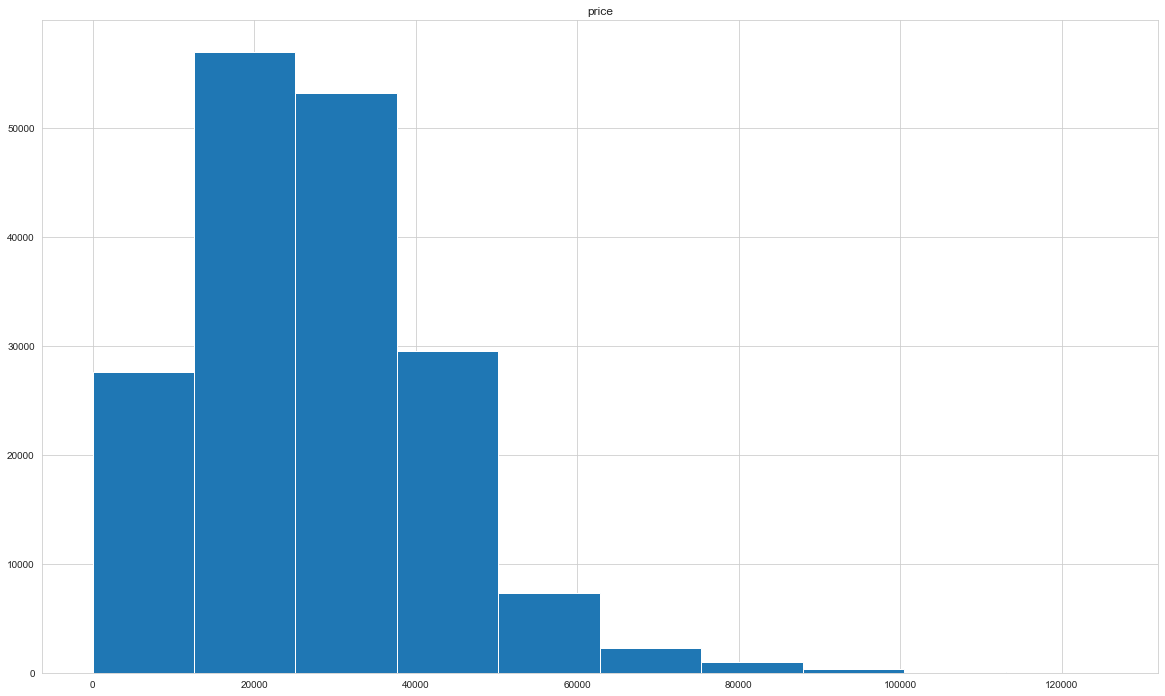

In [160]:
_ = df[["price"]].hist(figsize=(20,12))

In [161]:
# df["bought_total"] = df.bought_d1+df.bought_d2 + df.bought_d3+df.bought_d4+df.bought_d5

In [162]:
# def age_transform(row):
#     age = row.age_indicator
#     if age<10:
#         row['age_indicator']= 20
#     return row

In [163]:
# df = df.apply(lambda row: age_transform(row), axis=1)

In [164]:
df=df[feats]

In [165]:
df['current_program_starts_on_day'] = df['current_program_starts_on_day'].astype(int)
df['current_program_starts_on_month'] = df['current_program_starts_on_month'].astype(int)
df['current_program_starts_on_year'] = df['current_program_starts_on_year'].astype(int)

In [166]:
# df.info()

In [167]:
# df = df.fillna(0)

In [168]:
df

,program_id,price,cart_timestamp,control_month,student_id,age_indicator,feedback_avg_d1,feedback_avg_d3,feedback_avg_d5,feedback_avg_d4,...,current_program_starts_on_month,current_program_starts_on_year,time_diff,auto_payment,gender,platform,os,program_duration,communication_type,target
0,1469,20042.95930,1.598389e+09,9,6694527,32.0,5.0,0.000000,0.0,0.0,...,10,2020,4.060800e+06,0,1,2,5,0,1,0
3,1160,22260.63222,1.618348e+09,11,7151591,1.0,0.0,0.000000,0.0,0.0,...,9,2022,4.579200e+07,1,1,1,4,16,0,0
5,789,20050.68100,1.608412e+09,4,6784019,0.0,0.0,0.000000,0.0,5.0,...,8,2022,5.175360e+07,1,0,1,3,32,0,0
6,242,42893.16405,1.614373e+09,4,6409144,5.0,0.0,4.566105,0.0,0.0,...,8,2022,4.527360e+07,1,0,1,4,56,2,0
7,998,7206.92000,1.601759e+09,4,6314133,0.0,0.0,0.000000,0.0,0.0,...,8,2022,5.961600e+07,1,0,2,5,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,1562,36392.06906,1.625087e+09,9,7310456,21.0,0.0,0.000000,0.0,4.4,...,8,2022,3.620160e+07,1,1,1,4,52,2,0
199994,1330,11215.92501,1.629320e+09,9,7320106,10.0,0.0,0.000000,0.0,0.0,...,8,2022,3.119040e+07,0,0,1,4,12,0,0
199995,1043,10263.96745,1.602796e+09,11,6816668,27.0,0.0,0.000000,0.0,0.0,...,0,0,-1.602796e+09,1,1,2,5,0,0,0
199997,789,22084.06200,1.593378e+09,3,6670084,17.0,0.0,0.000000,0.0,4.0,...,8,2022,6.678720e+07,0,1,2,5,32,2,0


In [169]:
X =  df.drop(["target"], axis = 1)
y = df.target

In [170]:
X.columns

Index(['program_id', 'price', 'cart_timestamp', 'control_month', 'student_id',
       'age_indicator', 'feedback_avg_d1', 'feedback_avg_d3',
       'feedback_avg_d5', 'feedback_avg_d4', 'feedback_avg_d2', 'control_year',
       'support_feedback_avg', 'ABC', 'promo', 'bought_d1', 'bought_d2',
       'bought_d3', 'bought_d4', 'bought_d5', 'bought_avg_duration',
       'm_was_conversations', 'p_was_conversations',
       'program_family_main_direction_id', 'program_type',
       'program_starting_soon', 'current_program_starts_on_timestamp',
       'current_program_starts_on_day', 'current_program_starts_on_month',
       'current_program_starts_on_year', 'time_diff', 'auto_payment', 'gender',
       'platform', 'os', 'program_duration', 'communication_type'],
      dtype='object')

In [171]:

class_counts = Counter(y).most_common()
class_counts = dict([(cl[0], cl[1]) for cl in class_counts])
class_counts

{0: 152524, 1: 13512, 5: 3678, 4: 3659, 3: 3027, 2: 1823}

In [172]:
sample_class_counts = class_counts.copy()
sample_class_counts[2] = sample_class_counts[2] * 2
# sample_class_counts[3] = 4000
# sample_class_counts[5] = 4500

In [173]:
from imblearn.over_sampling import RandomOverSampler
over_sampler: RandomOverSampler = RandomOverSampler(sample_class_counts)
X, y = over_sampler.fit_resample(X, y)    

C:\Users\evvEn\PycharmProjects\netology\venv\lib\site-packages\imblearn\utils\_validation.py:586: FutureWarning: Pass sampling_strategy={0: 152524, 1: 13512, 5: 3678, 4: 3659, 3: 3027, 2: 3646} as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [174]:
# sample_class_counts[0] = 100_000

In [175]:
# from imblearn.under_sampling import RandomUnderSampler
# over_sampler: RandomUnderSampler = RandomUnderSampler(sample_class_counts)
# X, y = over_sampler.fit_resample(X, y)    

In [176]:
Counter(y).most_common()

[(0, 152524), (1, 13512), (5, 3678), (4, 3659), (2, 3646), (3, 3027)]

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [178]:
clf = RandomForestClassifier(random_state=0, max_depth=50, n_estimators=500)

In [179]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=500, random_state=0)

In [180]:
pred = clf.predict(X_test)

In [181]:
0.2* recall_score(y_test, pred, average='macro') + 0.8* precision_score(y_test, pred, average='macro')

0.9009318742056742

In [182]:
clf.classes_

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [183]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     45734
           1       0.93      0.71      0.81      4057
           2       0.94      0.92      0.93      1095
           3       0.92      0.69      0.79       932
           4       0.93      0.71      0.81      1081
           5       0.91      0.69      0.78      1115

    accuracy                           0.95     54014
   macro avg       0.93      0.78      0.85     54014
weighted avg       0.95      0.95      0.95     54014



In [184]:
importance_df = pd.DataFrame(clf.feature_importances_, columns=["value"],
                             index=clf.feature_names_in_).sort_values(by="value", ascending=False)
importance_df

,value
control_month,0.101519
cart_timestamp,0.098766
student_id,0.098598
time_diff,0.088160
price,0.077497
age_indicator,0.070992
program_id,0.040095
current_program_starts_on_timestamp,0.029249
current_program_starts_on_day,0.028082
m_was_conversations,0.025566


#Validation

In [185]:
df_test = pd.read_csv("./content/test_enriched.csv")

In [186]:
df_test["ABC"] = abc_le.transform(df_test["ABC"])

In [187]:
df_test['control_year'] = pd.to_datetime(df_test['month_id']).dt.strftime("%Y").astype(int)
df_test['control_month'] = pd.to_datetime(df_test['month_id']).dt.strftime("%m").astype(int)
df_test['control_timestamp'] = df_test['month_id'].apply(lambda d: time.mktime(datetime.strptime(d, "%m/%d/%Y").timetuple()))

df_test['cart_day'] = pd.to_datetime(df_test['carts_created_at']).dt.strftime("%d").astype(int)
df_test['cart_month'] = pd.to_datetime(df_test['carts_created_at']).dt.strftime("%m").astype(int)
df_test['cart_year'] = pd.to_datetime(df_test['carts_created_at']).dt.strftime("%Y").astype(int)
df_test['cart_timestamp'] = df_test['carts_created_at'].apply(lambda d: time.mktime(datetime.strptime(d, "%m/%d/%Y").timetuple()))

In [188]:
df_test['promo']=df['promo'].apply(lambda promo: promo =='+').astype(int)

In [189]:
df_test["communication_type"] = ct_le.transform(df_test["communication_type"])

In [190]:
df_test=df_test.apply(lambda row: os_trans(row), axis=1)
df_test["os"] = os_le.transform(df_test["os"])
df_test.platform=df_test.platform.apply(lambda p: 'mobile' if p =='tablet' else p)
df_test["platform"] = platform_le.transform(df_test["platform"])

In [191]:
df_test["program_type"] = program_type_le.transform(df_test["program_type"])
df_test["program_starting_soon"] = program_starting_soon_le.transform(df_test["program_starting_soon"])

In [192]:
program_family_price_type_le_dict = dict(zip(program_family_price_type_le.classes_, program_family_price_type_le.transform(program_family_price_type_le.classes_)))
df_test['program_family_price_type'] = df_test['program_family_price_type'].apply(lambda program_family_price_type: program_family_price_type_le_dict.get(program_family_price_type, -1))

In [193]:
df_test['current_program_starts_on_day'] = pd.to_datetime(df_test['current_program_starts_on']).dt.strftime("%d")
df_test['current_program_starts_on_month'] = pd.to_datetime(df_test['current_program_starts_on']).dt.strftime("%m")
df_test['current_program_starts_on_year'] = pd.to_datetime(df_test['current_program_starts_on']).dt.strftime("%Y")

In [194]:
df_test['current_program_starts_on_timestamp'] = df_test['current_program_starts_on'].apply(lambda d: to_timestamp(d))

In [195]:
df_test[['program_duration']]=df_test[['program_duration']].fillna('0 недель')
df_test=df_test.apply(lambda row: transform_duration(row), axis=1)

In [196]:
browser_le_dict = dict(zip(browser_le.classes_, browser_le.transform(browser_le.classes_)))
df_test['browser'] = df_test['browser'].apply(lambda browser: browser_le_dict.get(browser, -1))

In [197]:
# df_test = df_test.apply(lambda row: age_transform(row), axis=1)

In [198]:
# df_test = df_test.apply(lambda row: replace_country(row), axis=1)

In [199]:
# df_test["country"] = country_le.transform(df_test["country"])

In [200]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84997 entries, 0 to 84996
Data columns (total 77 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ABC                                  84997 non-null  int64  
 1   activity                             41481 non-null  float64
 2   age_indicator                        67548 non-null  float64
 3   auto_payment                         84997 non-null  int64  
 4   available_program_starts_on          80233 non-null  object 
 5   avg_hw_mark                          18909 non-null  float64
 6   avg_quiz_result                      6954 non-null   float64
 7   bought_avg_duration                  4277 non-null   float64
 8   bought_d1                            84997 non-null  int64  
 9   bought_d2                            84997 non-null  int64  
 10  bought_d3                            84997 non-null  int64  
 11  bought_d4                   

In [201]:
# mass_object_v = mass_object[mass_object!="target"]

In [202]:
# X_val = df_test.drop(mass_object_v, axis = 1)

In [203]:
df_test = df_test.fillna(0)

In [204]:
df_test["time_diff"] = df_test["current_program_starts_on_timestamp"] - df_test["cart_timestamp"]

In [205]:
df_test.gender=df_test.gender.astype(int)

In [206]:
# df_test=df_test.apply(lambda row: price_trans(row), axis=1)

In [207]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84997 entries, 0 to 84996
Data columns (total 78 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ABC                                  84997 non-null  int64  
 1   activity                             84997 non-null  float64
 2   age_indicator                        84997 non-null  float64
 3   auto_payment                         84997 non-null  int64  
 4   available_program_starts_on          84997 non-null  object 
 5   avg_hw_mark                          84997 non-null  float64
 6   avg_quiz_result                      84997 non-null  float64
 7   bought_avg_duration                  84997 non-null  float64
 8   bought_d1                            84997 non-null  int64  
 9   bought_d2                            84997 non-null  int64  
 10  bought_d3                            84997 non-null  int64  
 11  bought_d4                   

In [208]:
# mass_object_v = mass_object[mass_object!="target"]

In [209]:
# X_val = df_test.drop(mass_object_v, axis = 1)

In [210]:
df_test = df_test.fillna(0)

In [211]:
df_test['current_program_starts_on_day'] = df_test['current_program_starts_on_day'].astype(int)
df_test['current_program_starts_on_month'] = df_test['current_program_starts_on_month'].astype(int)
df_test['current_program_starts_on_year'] = df_test['current_program_starts_on_year'].astype(int)

In [212]:
df_test["time_diff"] = df_test["current_program_starts_on_timestamp"] - df_test["cart_timestamp"]

In [213]:
df_test.gender=df_test.gender.astype(int)

In [214]:
# df_test=df_test.apply(lambda row: price_trans(row), axis=1)

In [215]:
X_val=df_test[x_feats]

In [216]:
pred_test = clf.predict(X_val)

In [217]:
df_test["target"] = pred_test

In [218]:
df_test=df_test[["id", "target"]]

In [219]:
df_test.to_csv("./content/pred.csv", index=False)

In [220]:
from collections import Counter
class_counts = Counter(df_test.target).most_common()
class_counts = dict([(cl[0], cl[1]) for cl in class_counts])
class_counts

{0: 76965, 1: 4241, 4: 1138, 5: 1102, 3: 920, 2: 631}

In [221]:
pred_test = clf.predict(X_val)

In [222]:
df_test["target"] = pred_test

In [223]:
df_test=df_test[["id", "target"]]

In [224]:
df_test.to_csv("./content/pred.csv", index=False)

In [225]:
from collections import Counter
class_counts = Counter(df_test.target).most_common()
class_counts = dict([(cl[0], cl[1]) for cl in class_counts])
class_counts

{0: 76965, 1: 4241, 4: 1138, 5: 1102, 3: 920, 2: 631}